In [1]:
import os

In [2]:
os.chdir("../Documents/Physio_Ca/")

In [3]:
import numpy as np
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sys import path as syspath
syspath.append("./functions/")
from physio_def_1 import *

In [4]:
import scipy.signal as signal

In [5]:
import pandas as pd

In [6]:
from matplotlib.colors import LogNorm

In [63]:
from os import chdir
#chdir("/Volumes/CTNC_backup/Projects/ER_Sandra/Leica/")
# chdir("/Volumes/CTNC_backup/Projects/Maribor/TheBest/")
# chdir("")
#chdir("/Volumes/CTNC_backup/Projects/ER_Sandra/Nikon/")
#chdir("/Volumes/CTNC_backup/Projects/Maribor/TheBest/2013_03_19")

In [7]:
%%time
#much fast if previously downloaded
#allData = np.load('/Volumes/physio/team/slakrupnik/project/Python/Experiment38c_Series009.npy')
# allData = np.load('Experiment38b_Series054.npy')
dataFilename = '/Users/srdjan/Documents/Physio_Ca/data/Experiment_22_Series059.npz'
npzFile = np.load(dataFilename)

CPU times: user 1.89 ms, sys: 4.57 ms, total: 6.46 ms
Wall time: 9.6 ms


In [9]:
metadata = pd.read_csv(dataFilename.replace("npz","txt"), index_col=0).iloc[0]
metadata

T               14
X               64
Y             8192
freq      0.697799
pxSize     2.67314
pxUnit          µm
Name: 0, dtype: object

In [10]:
metadata["pxSize"]

2.6731396825396825

In [11]:
# from numba import jit
# @jit 
def decay(time,top,bottom,rate):
#     top,bottom,rate = p
    return bottom+(top-bottom)*np.exp(-time*rate)
from scipy.optimize import curve_fit
def guessDecayPars(y):
    b0 = np.nanmin(y)
    y = np.log(y-b0)
    r0 = np.diff(y)
    r0 = -np.nanmean(r0[:len(r0)//2])
    t0 = np.nanpercentile(y,99)
    p0 = (np.exp(t0)+b0,b0,r0)
    return p0
def decayfit(x):
    p0 = guessDecayPars(x)
    ff = np.isfinite(x)
    tt = np.arange(len(x))
    popt = curve_fit(decay,tt[ff],x[ff],p0=p0)[0]
    expDecay = decay(tt,*popt)
    return expDecay
def percFilter(x_,perc,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.percentile(x_[i:i+filterSize],perc)
    return out
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out

In [12]:
time = npzFile["time"]
allData = npzFile["data"]

In [19]:
## suppose this is a criterion of whether this is a line scan
lineScan = metadata["Y"]>2000

In [22]:
if lineScan:
    metadata["freq"] = metadata["freq"]*metadata["Y"]
    metadata["T"]    = metadata["T"]   *metadata["Y"]
    metadata["Y"]    = 1
    allData = np.vstack(allData).reshape((metadata["T"],metadata["X"],1))
    time = np.arange(metadata["T"])/metadata["freq"]

In [24]:
allData.shape

(114688, 64, 1)

In [27]:
metadata

T          114688
X              64
Y               1
freq      5716.37
pxSize    2.67314
pxUnit         µm
Name: 0, dtype: object

In [54]:
roiWidth = 1
x0, Nx = 0,metadata["X"]//roiWidth
y0, Ny = 0,1
RoiOrigins = np.array([(x0+i*roiWidth,y0+j*roiWidth) for i in range(Nx)
                          for j in range(Ny)])

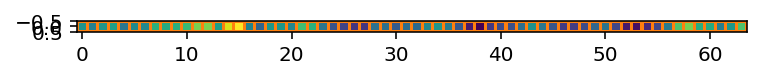

In [55]:
plt.figure()
ax = plt.subplot(111)
plt.imshow(allData[:100].mean(0).T,norm=LogNorm())
addRoisToImage(RoiOrigins,roiWidth,ax=ax,label=False)

In [56]:
roiProfiles = getRoiProfiles(RoiOrigins,roiWidth,image_=allData)

In [57]:
assert np.equal(
    np.mean(list(roiProfiles.values()), axis=0),
    allData.mean(axis=(1,2))
        ).all()

In [58]:
pos = np.array(RoiOrigins)+roiWidth/2
ncells = len(roiProfiles)

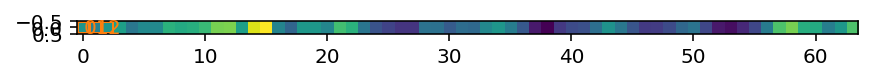

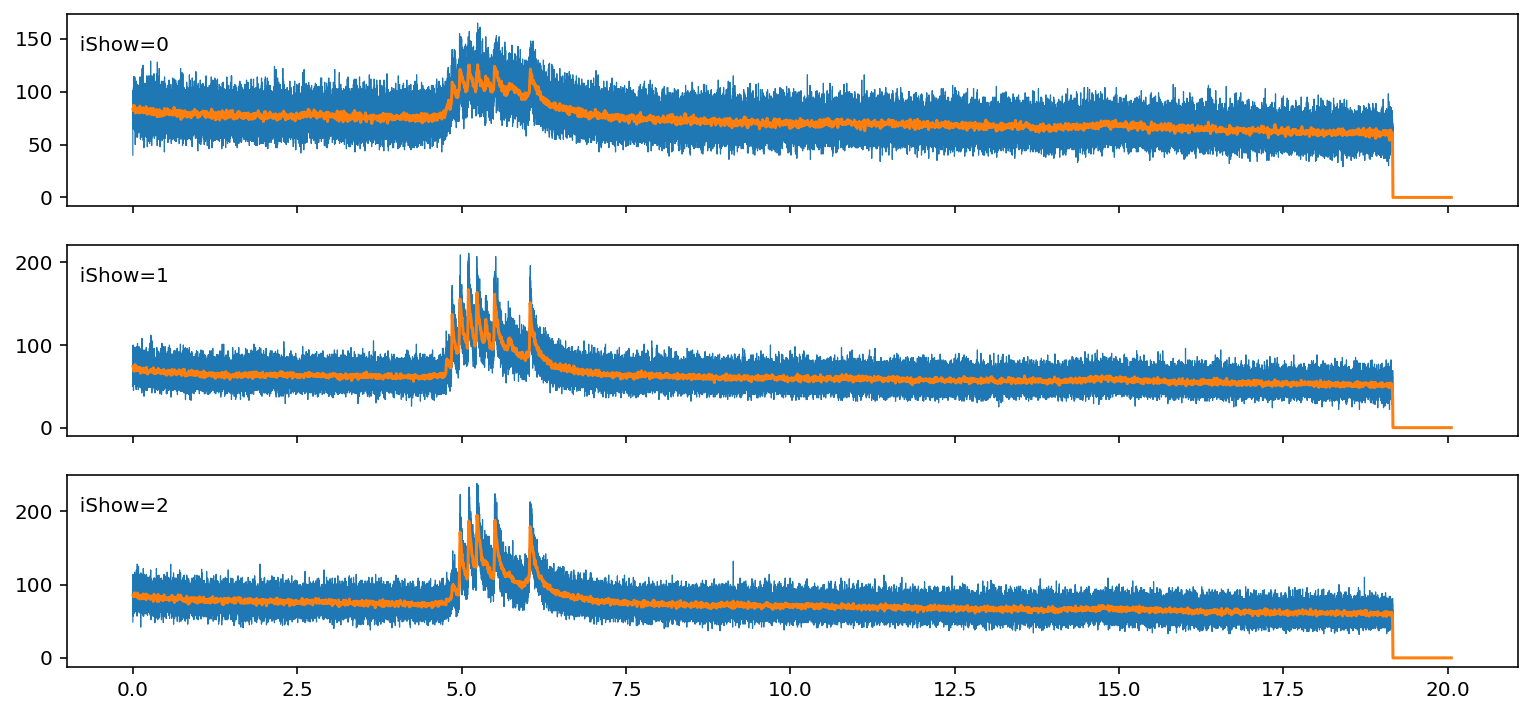

In [60]:
showRois = range(3)
plt.figure(figsize=(7,7))
ax = plt.subplot(111)
plt.imshow(allData[:100].mean(0).T,norm=LogNorm())
addRoisToImage({jj:RoiOrigins[jj] for jj in showRois},roiWidth,ax=ax,label=True)

tWin = 30
rebinnedTime = rebin(time,tWin)
fig, axs = plt.subplots(len(showRois),1,figsize=(13,2*len(showRois)), sharex=True)
for iShow,ax in zip(showRois,axs):
    ax.plot(time,roiProfiles[iShow], lw=.6)
    ax.plot(rebinnedTime,rebin(roiProfiles[iShow],tWin))
    ax.text(0,1,"\n  iShow=%i"%iShow,va="top",transform=ax.transAxes)

In [61]:
# So, we can reduce the number of points to save time
ts = np.vstack(list(roiProfiles.values()))
ts = rebin(ts,tWin, axis=1)

In [68]:
# There is something strange at the end. Let's kick this out
tEnd = 18
ts = ts[:,rebinnedTime<tEnd]
rebinnedTime = rebinnedTime[rebinnedTime<tEnd]

In [70]:
ts.shape, rebinnedTime.shape

((64, 3430), (3430,))

In [ ]:
def decay(time,top,bottom,rate):
#     top,bottom,rate = p
    return bottom+(top-bottom)*np.exp(-time*rate)
from scipy.optimize import curve_fit

def guessDecayPars(y):
    b0 = np.nanmin(y)
    y  = np.log(y-b0)
    r0 = np.diff(y)
    r0 = r0[np.isfinite(r0)]
    r0 = -np.mean(r0)
    t0 = np.nanpercentile(y,99)
    p0 = (np.exp(t0)+b0,b0,r0)
    return p0

def decayfit(x,Ntrials=None):
    if Ntrials is None:
        lx = 10
    else:
        lx = Ntrials
    nx = len(x)//10
    TT = np.arange(len(x))
    tt = TT.copy()
    for j_ in range(lx):
        try:
            p0 = guessDecayPars(x)
            ff = np.isfinite(x)
            popt = curve_fit(decay,tt[ff],x[ff],p0=p0)[0]
            expDecay = decay(TT,*popt)
            return expDecay
        except:
            x = x[:-nx]
            tt = tt[:-nx]
    return p0

def percFilter(x_,perc,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.percentile(x_[i:i+filterSize],perc)
    return out
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out

In [226]:
typicalFeatureLengthInSeconds = 2
deltaT = np.diff(rebinnedTime)[0]
wIron = int(2*typicalFeatureLengthInSeconds/deltaT)
if not wIron%2: wIron += 1

In [227]:
# so let's collect all steps in one function:
def customFilter(x, wIron, wAvg, plot=False, rasterThreshold=None):
    ironedx = percFilter(x, 3, wIron)
    ironedx = runningAverage(ironedx,wIron)
    if plot:
        fig, axs = plt.subplots(4,1,figsize=(14,9), sharex=True)
        axs[0].plot(x,lw=0.6)
        axs[0].plot(ironedx)
        xl = axs[0].get_xlim()
    x = x-ironedx
    x = runningAverage(x,wAvg)
    xstore = x.copy()
    # define median and mad (median absolute deviation)
    md = percFilter(x,50,wIron*3)
    sd = percFilter(np.abs(x-md),50,wIron*3)*1.48
    x[x>md+3*sd] = np.nan
    x[x<md-3*sd] = np.nan
    decayLine = decayfit(x)
    if plot:
        axs[1].plot(xstore,lw=0.6)
        axs[1].plot(x,lw=0.6)
        axs[1].plot(decayLine,lw=0.6)
    x = x-decayLine
    xstore = xstore-decayLine
    m,s = np.nanmean(x), np.nanstd(x)
    xstore = xstore-m
    if plot:
        ax = axs[2]
        ax.plot(xstore,lw=0.6)
        if rasterThreshold is None:
            nss = np.arange(4)
            for ns in nss:
                ax.fill_between(xl,[-ns*s]*2,[+ns*s]*2, color="grey",alpha = .1)
        else:
            ax.axhline(rasterThreshold,lw=.7,color="grey")
            
        ax.set_xlim(xl)
    if rasterThreshold is None:
        return xstore
    else:
        raster = (xstore>rasterThreshold).astype(int)
        if plot:
            axs[-1].plot(raster)
        return xstore, raster

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


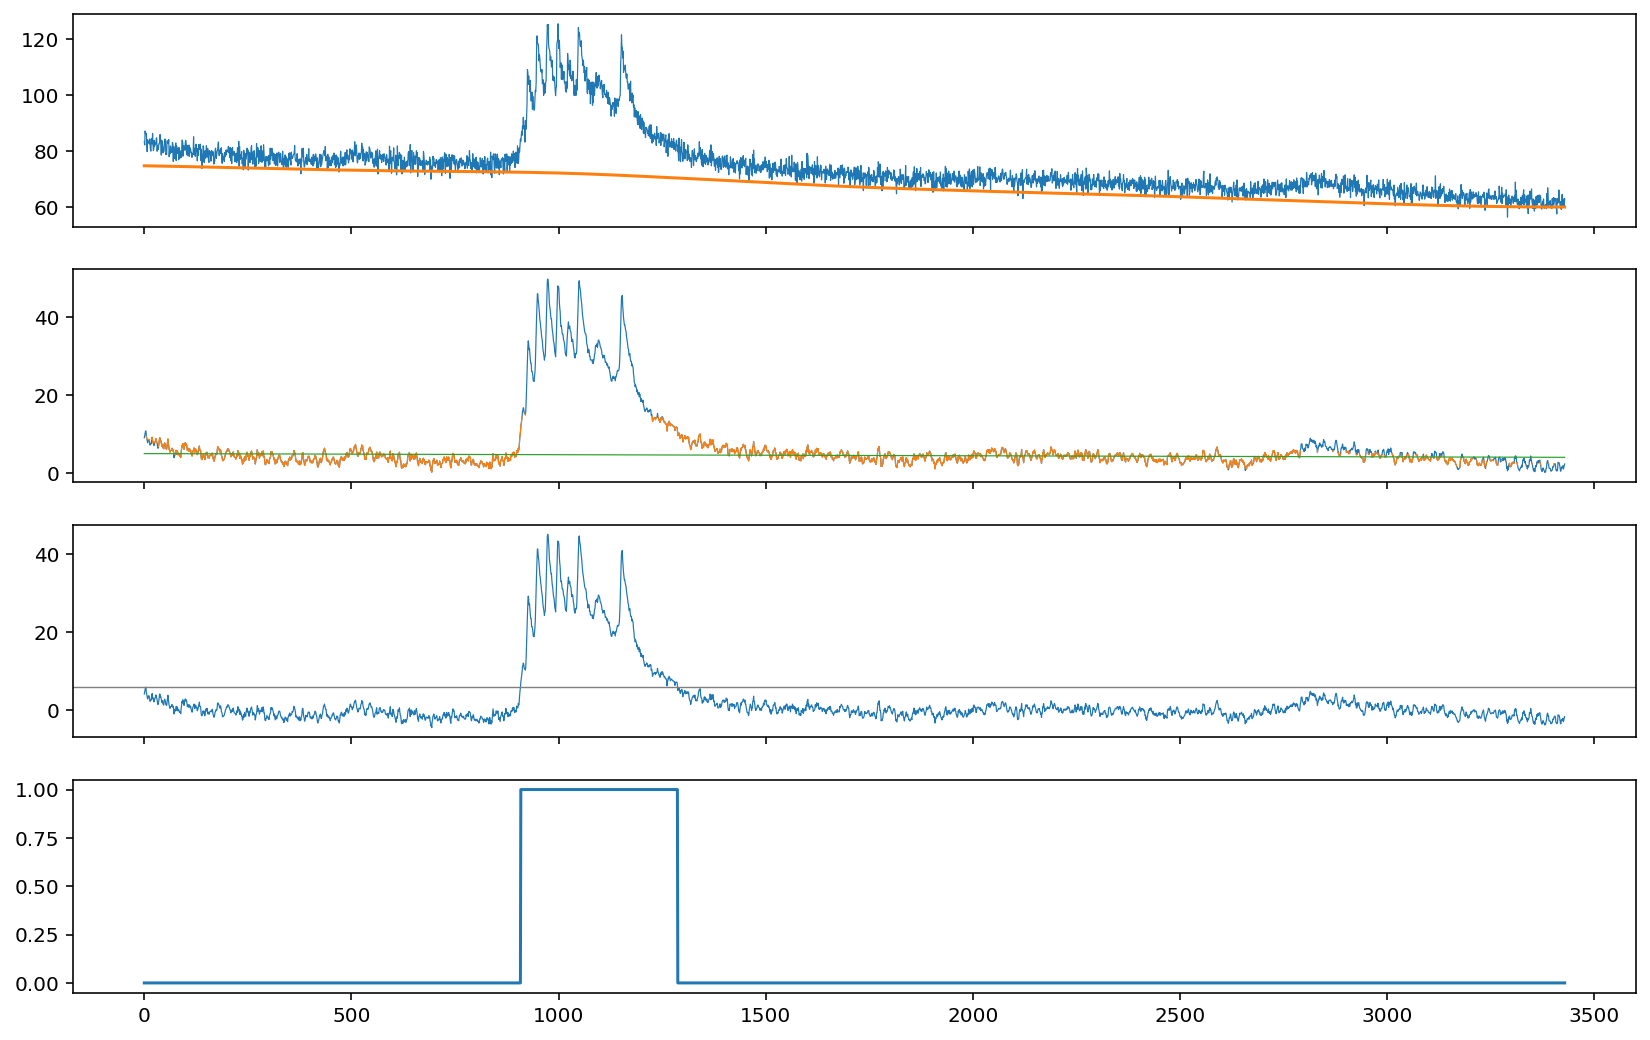

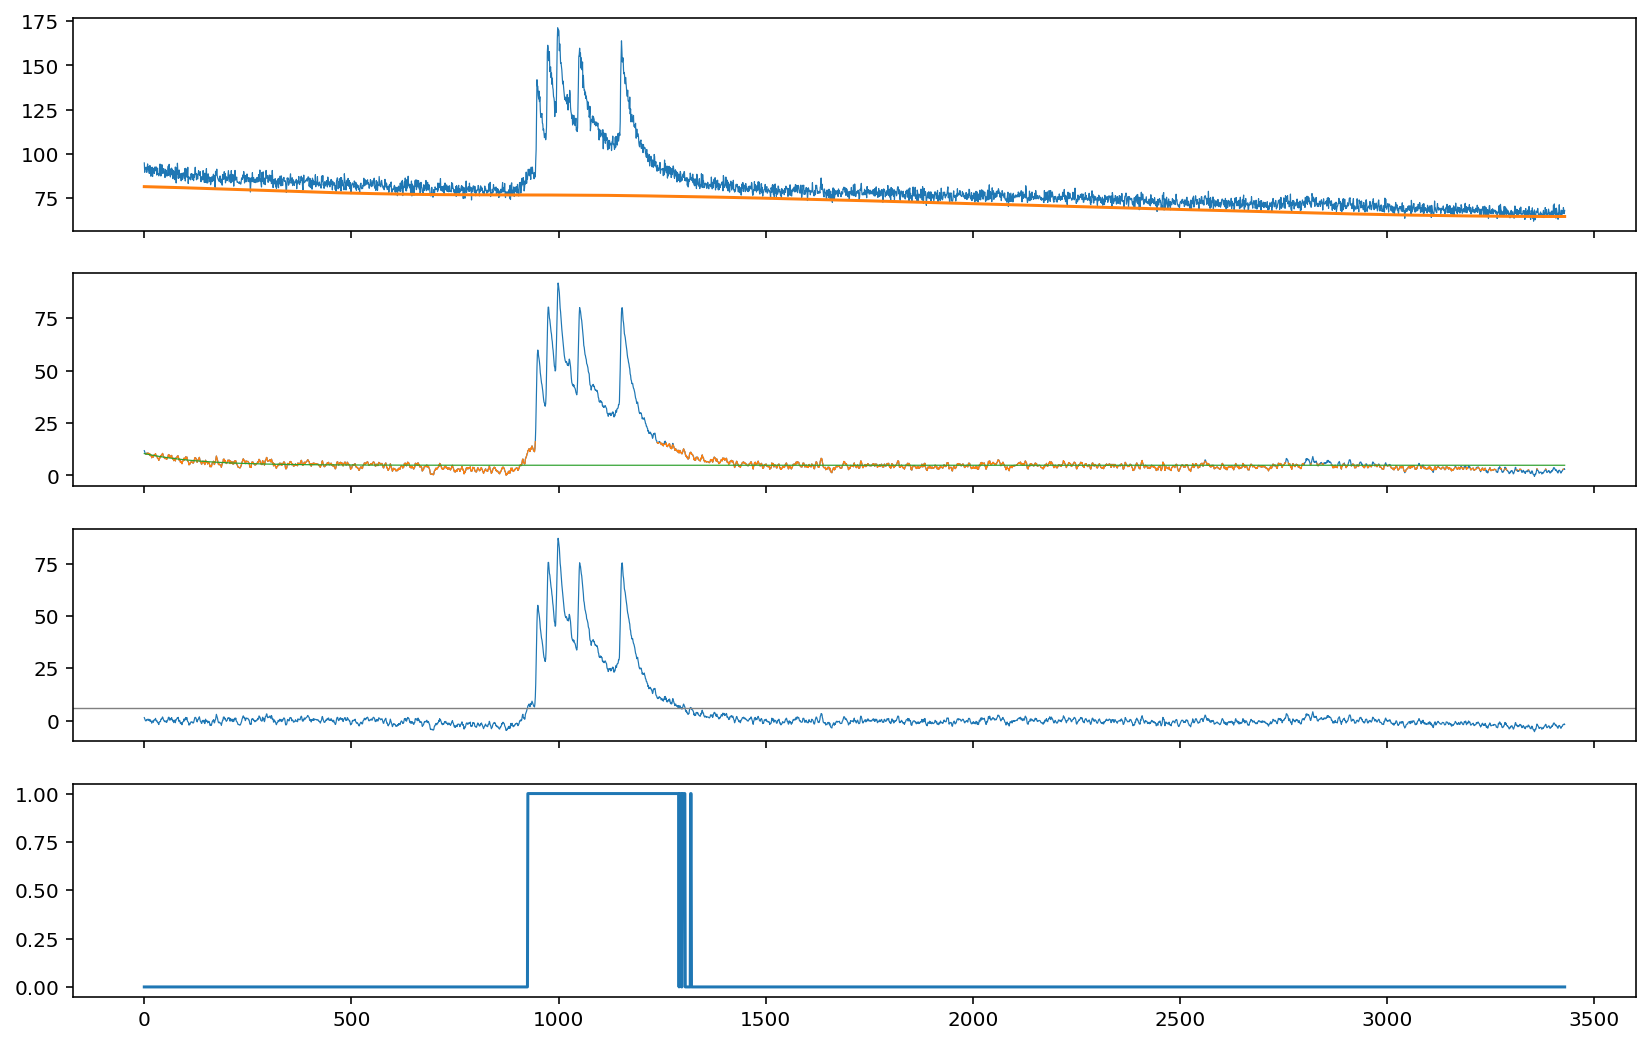

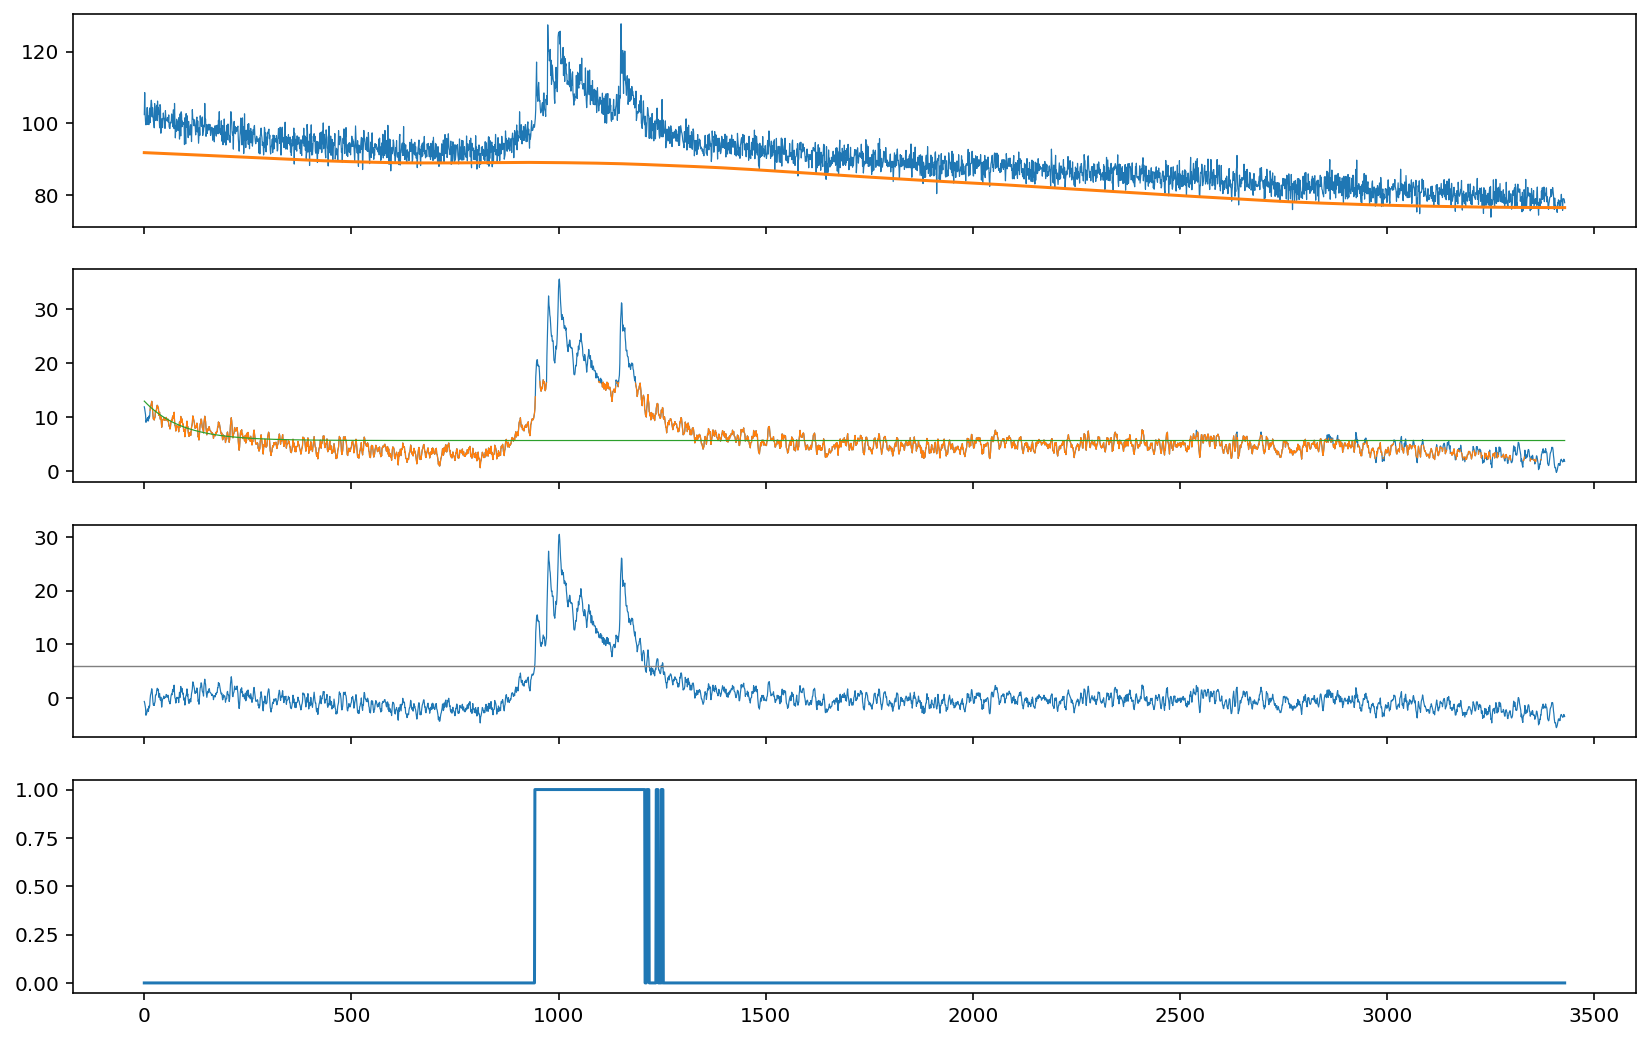

In [232]:
for iExamine in [0,3,7]:
    xf,raster = customFilter(ts[iExamine],
                             wIron=wIron,
                             wAvg=5,
                             plot=True,
                             rasterThreshold=6)

In [233]:
NRois = ncells

In [242]:
%%time
detrendedAndFiltered = np.zeros_like(ts)
rasterImage = np.zeros_like(ts).astype(np.uint8)
for i in range(NRois):
    xf,raster = customFilter(ts[i],wIron=wIron,wAvg=5, plot=False,rasterThreshold=6)
    detrendedAndFiltered[i] = xf
    rasterImage[i] = raster

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 2min 22s, sys: 767 ms, total: 2min 23s
Wall time: 2min 24s


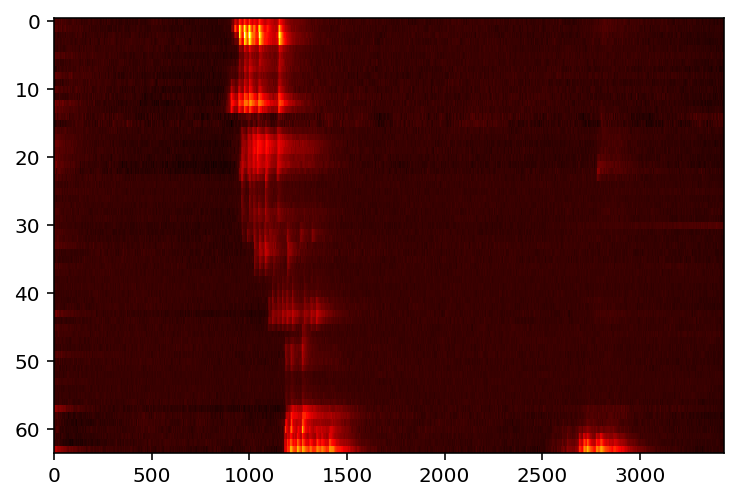

In [243]:
plt.figure()
plt.imshow(detrendedAndFiltered, cmap="hot", )
plt.gca().set_aspect("auto")

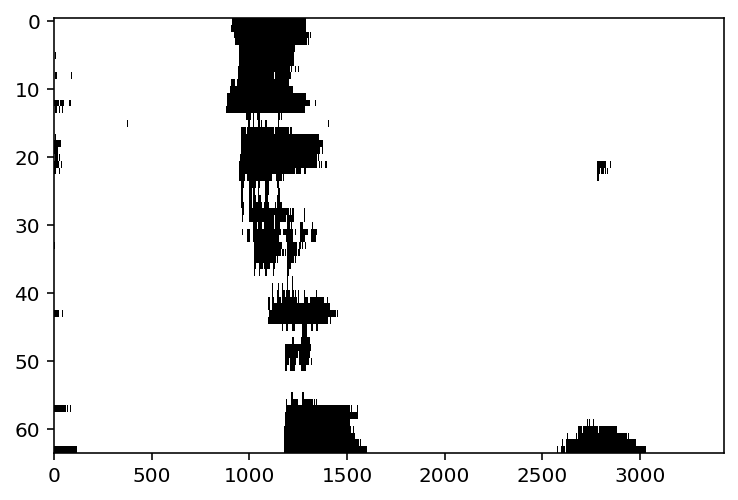

In [244]:
plt.figure()
plt.imshow(rasterImage, cmap="gray_r")
plt.gca().set_aspect("auto")

In [ ]:
# np.save('Experiment_18_Series051_raster.npy', rasterImage)

In [ ]:
# raster = np.load('Experiment_18_Series051_raster.npy')

In [237]:
# raster.shape

In [238]:
# plt.figure()
# plt.imshow(raster, cmap="gray_r")
# plt.gca().set_aspect("auto")